In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import ghibtools as gh
import xarray as xr
import matplotlib.pyplot as plt
from params import subject_keys, eeg_chans, run_keys
from compute_global_dataframes import coherence_at_resp_concat_job, oas_concat_job, bmrq_concat_job
from bibliotheque import get_pos, init_nan_da, df_baseline, keep_clean, get_df_mask_chan_signif
import mne
import os
from configuration import base_folder
from params import *

# LOAD DATA

In [3]:
pos = get_pos()

In [4]:
coherence = coherence_at_resp_concat_job.get(global_key).to_dataframe()

In [5]:
indexes = ['participant','session','chan']
metrics = ['fmax_resp','max_resp','max_coherence','log_max_coherence']

In [6]:
coherence = coherence.set_index(indexes + ['Gender']).astype(float).reset_index()
coherence['log_max_coherence'] = np.log(coherence['max_coherence'])
coherence = keep_clean(coherence, metrics)

In [7]:
coherence

,index,participant,session,chan,Gender,fmax_resp,max_resp,max_coherence,stai_state,stai_trait,keep_session,Maia_Mean,OAS,BMRQ,log_max_coherence
0,0,P01,baseline,Fp1,F,0.356259,866.407169,0.024449,40.0,61.0,1.0,1.019643,2.666667,2.727273,-3.711157
1,1,P01,baseline,Fz,F,0.356259,866.407169,0.072840,40.0,61.0,1.0,1.019643,2.666667,2.727273,-2.619490
2,2,P01,baseline,F3,F,0.356259,866.407169,0.095314,40.0,61.0,1.0,1.019643,2.666667,2.727273,-2.350575
3,3,P01,baseline,F7,F,0.356259,866.407169,0.026821,40.0,61.0,1.0,1.019643,2.666667,2.727273,-3.618577
4,4,P01,baseline,FT9,F,0.356259,866.407169,0.058682,40.0,61.0,1.0,1.019643,2.666667,2.727273,-2.835616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2785,2785,P31,odor,FC6,M,0.187505,3108.048063,0.241742,29.0,40.0,1.0,2.790774,2.933333,2.681818,-1.419886
2786,2786,P31,odor,FC2,M,0.187505,3108.048063,0.151601,29.0,40.0,1.0,2.790774,2.933333,2.681818,-1.886501
2787,2787,P31,odor,F4,M,0.187505,3108.048063,0.506776,29.0,40.0,1.0,2.790774,2.933333,2.681818,-0.679687
2788,2788,P31,odor,F8,M,0.187505,3108.048063,0.272262,29.0,40.0,1.0,2.790774,2.933333,2.681818,-1.300991


In [8]:
coherence_baselined = df_baseline(coherence, indexes, metrics, mode = 'substract')

In [9]:
coherence_baselined

,participant,session,chan,fmax_resp,max_resp,max_coherence,log_max_coherence
0,P01,odor,Fp1,0.000000,-449.015372,-0.011617,-0.644609
1,P01,odor,Fz,0.000000,-449.015372,-0.009603,-0.141379
2,P01,odor,F3,0.000000,-449.015372,-0.033749,-0.437088
3,P01,odor,F7,0.000000,-449.015372,-0.023511,-2.092176
4,P01,odor,FT9,0.000000,-449.015372,-0.049088,-1.810957
...,...,...,...,...,...,...,...
1855,P31,music,FC6,-0.075002,3304.836158,0.284569,3.197102
1856,P31,music,FC2,-0.075002,3304.836158,0.191901,2.220561
1857,P31,music,F4,-0.075002,3304.836158,0.367052,1.848088
1858,P31,music,F8,-0.075002,3304.836158,0.359002,4.611530


# STATS ENTRE CONDITIONS

<AxesSubplot: >

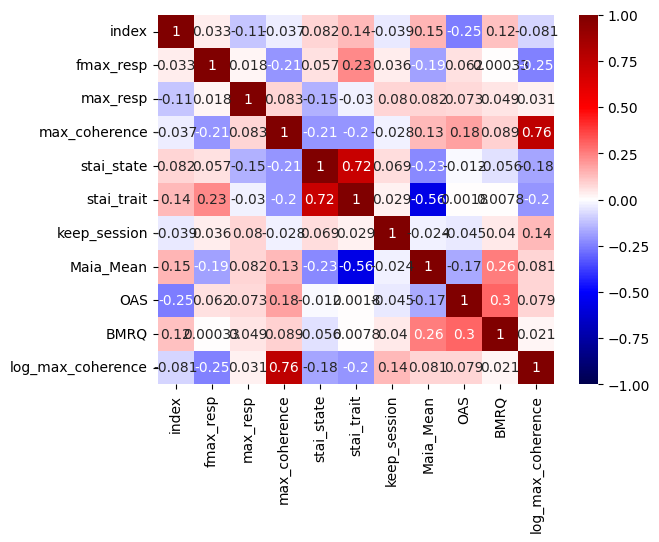

In [10]:
sns.heatmap(coherence.corr(numeric_only = True), cmap = 'seismic', vmin = -1 , vmax = 1 , annot = True)

<AxesSubplot: ylabel='Frequency'>

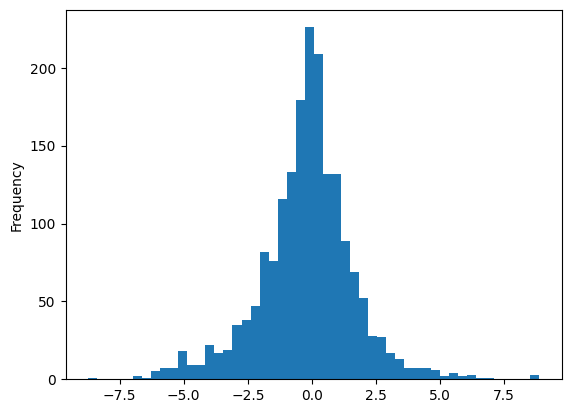

In [11]:
coherence_baselined['log_max_coherence'].plot.hist(bins = 50)

<AxesSubplot: ylabel='Frequency'>

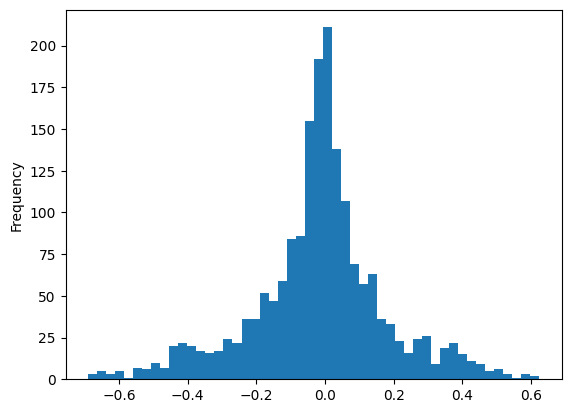

In [12]:
coherence_baselined['max_coherence'].plot.hist(bins = 50)

/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


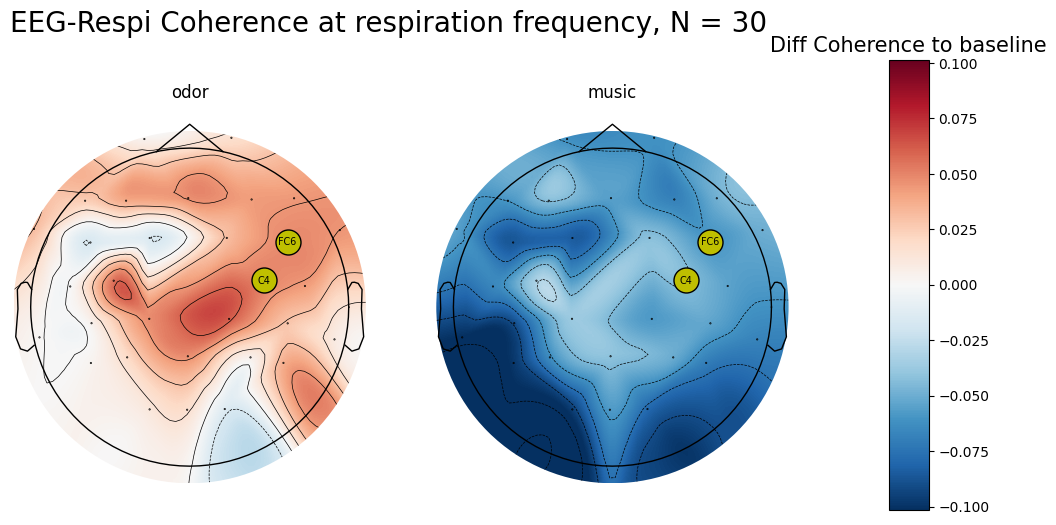

In [13]:
q_diff = 0.

metric = 'max_coherence'

df = coherence_baselined.copy()

mask_params = dict(markersize=18, markerfacecolor='y')
df_mask = get_df_mask_chan_signif(df = df, chans = eeg_chans, predictor = 'session', outcome = metric, subject = 'participant', multicomp_method = 'bonf', stats_type = 'classic')


N = df['participant'].unique().size

vmin = df.groupby(['session','chan']).mean(numeric_only = True)[metric].quantile(q_diff)
vmax = df.groupby(['session','chan']).mean(numeric_only = True)[metric].quantile(1 - q_diff)

vmin = vmin if abs(vmin) > abs(vmax) else -vmax
vmax = vmax if abs(vmax) > abs(vmin) else abs(vmin)

fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
fig.suptitle(f'EEG-Respi Coherence at respiration frequency, N = {N}', fontsize = 20, y = 1.1)

for c, session in enumerate(df['session'].unique()):
    ax = axs[c]
    topo_data = df[df['session'] == session].groupby('chan').mean(numeric_only = True)[metric].reindex(eeg_chans)
    im, cn = mne.viz.plot_topomap(data = topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax), mask = df_mask['mask_corr'], mask_params = mask_params)
    ax.set_title(f'{session}')
        
ax_x_start = 1
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('Diff Coherence to baseline',fontsize=15)

file = base_folder / 'Figures' / 'coherence_at_resp' / 'coherence_substract_baseline_stats_classiques.png'

fig.savefig(file, bbox_inches = 'tight')
    
fig.show()

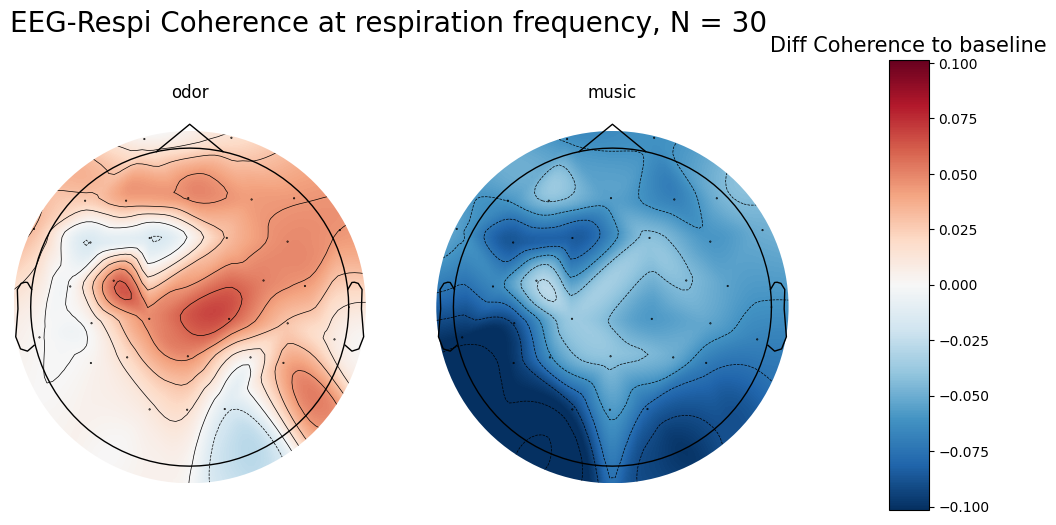

In [14]:
q_diff = 0.

metric = 'max_coherence'

df = coherence_baselined.copy()

mask_params = dict(markersize=18, markerfacecolor='y')
df_mask = get_df_mask_chan_signif(df = df, chans = eeg_chans, predictor = 'session', outcome = metric, subject = 'participant', multicomp_method = 'bonf', stats_type = 'permutations')


N = df['participant'].unique().size

vmin = df.groupby(['session','chan']).mean(numeric_only = True)[metric].quantile(q_diff)
vmax = df.groupby(['session','chan']).mean(numeric_only = True)[metric].quantile(1 - q_diff)

vmin = vmin if abs(vmin) > abs(vmax) else -vmax
vmax = vmax if abs(vmax) > abs(vmin) else abs(vmin)

fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
fig.suptitle(f'EEG-Respi Coherence at respiration frequency, N = {N}', fontsize = 20, y = 1.1)

for c, session in enumerate(df['session'].unique()):
    ax = axs[c]
    topo_data = df[df['session'] == session].groupby('chan').mean(numeric_only = True)[metric].reindex(eeg_chans)
    im, cn = mne.viz.plot_topomap(data = topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax), mask = df_mask['mask_corr'], mask_params = mask_params)
    ax.set_title(f'{session}')
        
ax_x_start = 1
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('Diff Coherence to baseline',fontsize=15)

file = base_folder / 'Figures' / 'coherence_at_resp' / 'coherence_substract_baseline_stats_permutations.png'

fig.savefig(file, bbox_inches = 'tight')
    
fig.show()

In [15]:
oas = oas_concat_job.get(global_key).to_dataframe().set_index('participant')
bmrq = bmrq_concat_job.get(global_key).to_dataframe().set_index('participant')

In [16]:
q_diff = 0.

metric = 'max_coherence'

for subject in subject_keys:
    
    bmrq_sub = bmrq.loc[subject, 'BMRQ'].round(3)
    oas_sub = oas.loc[subject, 'OAS'].round(3)
    
    df = coherence_baselined[coherence_baselined['participant'] == subject]

    vmin = df.groupby(['session','chan']).mean(numeric_only = True)[metric].quantile(q_diff)
    vmax = df.groupby(['session','chan']).mean(numeric_only = True)[metric].quantile(1 - q_diff)
    
    vmin = vmin if abs(vmin) > abs(vmax) else -vmax
    vmax = vmax if abs(vmax) > abs(vmin) else abs(vmin)

    fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
    fig.suptitle(f'EEG-Respi LogCoherence at respiration frequency, sub = {subject} \n OAS : {oas_sub} - BMRQ : {bmrq_sub}', fontsize = 20, y = 1.1)

    for c, session in enumerate(df['session'].unique()):
        ax = axs[c]
        topo_data = df[df['session'] == session].groupby('chan').mean(numeric_only = True)[metric].reindex(eeg_chans)
        im, cn = mne.viz.plot_topomap(data = topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax))
        ax.set_title(f'{session}')

    ax_x_start = 1
    ax_x_width = 0.04
    ax_y_start = 0.1
    ax_y_height = 0.9
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    clb.ax.set_title('Coherence to baseline',fontsize=15)

    file = base_folder / 'Figures' / 'coherence_at_resp' / 'by_subject' / f'{subject}.png'
    

    fig.savefig(file, bbox_inches = 'tight')

    plt.close()

# STATS VS BASELINE

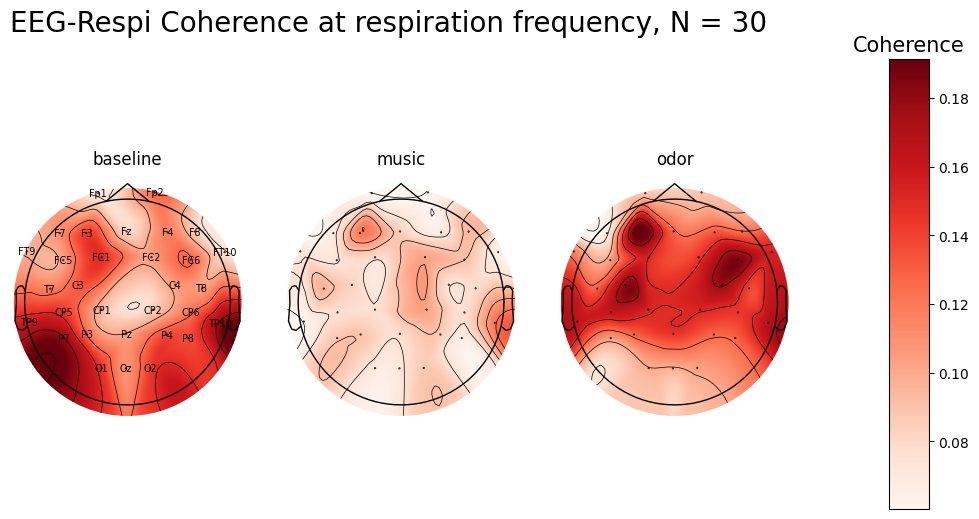

In [17]:
df = coherence.copy()

dfs_masks = []
for cond in ['odor','music']:
    df_to_mask = df[df['session'].isin(['baseline',cond])]
    df_mask = get_df_mask_chan_signif(df = df_to_mask, 
                                      chans = eeg_chans, 
                                      predictor = 'session',
                                      outcome = metric, 
                                      subject = 'participant',
                                      multicomp_method = 'bonf',
                                      stats_type = 'permutations',
                                      diff = 'median')
    df_mask['cond'] = cond
    dfs_masks.append(df_mask)
dfs_masks = pd.concat(dfs_masks)

mask_params = dict(markersize=15, markerfacecolor='y')

N = df['participant'].unique().size

vmin = df.groupby(['session','chan']).median(numeric_only = True)[metric].quantile(q_diff)
vmax = df.groupby(['session','chan']).median(numeric_only = True)[metric].quantile(1 - q_diff)

# vmin = vmin if abs(vmin) > abs(vmax) else -vmax
# vmax = vmax if abs(vmax) > abs(vmin) else abs(vmin)

fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
fig.suptitle(f'EEG-Respi Coherence at respiration frequency, N = {N}', fontsize = 20, y = 1.1)

for c, session in enumerate(df['session'].unique()):
    ax = axs[c]
    df_mask = dfs_masks[dfs_masks['cond'] == session]
    topo_data = df[df['session'] == session].groupby('chan').median(numeric_only = True)[metric].reindex(eeg_chans)
    if session == 'baseline':
        im, cn = mne.viz.plot_topomap(data = topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax))
    else:
        im, cn = mne.viz.plot_topomap(data = topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax), mask = df_mask['mask_corr'], mask_params = mask_params)
    ax.set_title(f'{session}')
        
ax_x_start = 1
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('Coherence',fontsize=15)

file = base_folder / 'Figures' / 'coherence_at_resp' / 'raw_coherence_stats_permutations.png'
fig.savefig(file, bbox_inches = 'tight')
plt.show()

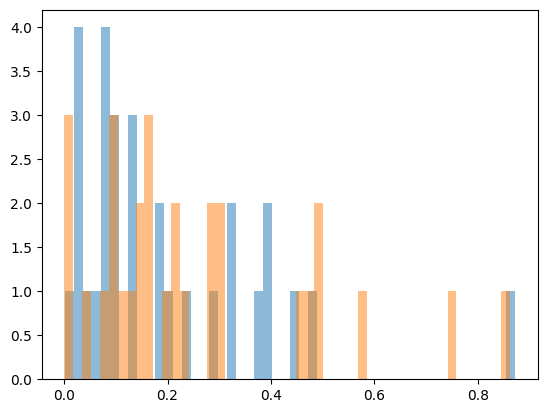

In [18]:
chan = 'C3'
x_df = df[(df['session'] == 'baseline') & (df['chan'] == chan)]
y_df = df[(df['session'] == 'odor') & (df['chan'] == chan)]
x = x_df['max_coherence'].values
y = y_df['max_coherence'].values

fig, ax = plt.subplots()
bins = 50
ax.hist(x, bins = bins, alpha = 0.5)
ax.hist(y, bins = bins, alpha = 0.5)
plt.show()

In [19]:
x

array([0.23219577, 0.1839639 , 0.2076058 , 0.07886607, 0.03055621,
       0.13476629, 0.09575588, 0.17645172, 0.07216154, 0.05404875,
       0.31755776, 0.38350929, 0.02227638, 0.09886725, 0.39303672,
       0.00159063, 0.39645051, 0.07526107, 0.4750092 , 0.87254293,
       0.09349427, 0.33122352, 0.0375582 , 0.1364813 , 0.13108732,
       0.07365442, 0.03507431, 0.29676585, 0.45087844, 0.02028171])

In [20]:
y

array([9.85659810e-02, 4.65285811e-01, 9.93275328e-02, 1.49711782e-01,
       1.91974604e-01, 5.85759132e-01, 2.31728543e-01, 1.67725244e-01,
       3.06532299e-01, 4.75871213e-01, 3.05403708e-01, 7.54854504e-01,
       1.71724940e-01, 9.34634747e-02, 4.87419056e-01, 1.61399625e-02,
       2.12264429e-01, 1.16752773e-01, 4.88380657e-01, 8.62491058e-01,
       2.29172410e-04, 1.41028594e-01, 1.72054091e-01, 8.22791773e-02,
       3.56643438e-02, 2.88161054e-01, 1.60645918e-03, 1.36286188e-01,
       2.08907852e-01, 2.78492446e-01])

In [21]:
from scipy import stats

In [22]:
def statistic(x,y):
    return np.median(x) - np.median(y)

In [23]:
res = stats.permutation_test(data=[x,y], statistic=statistic, permutation_type='samples', n_resamples=1000)

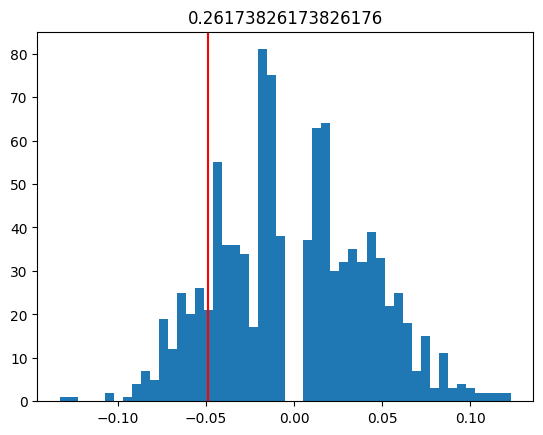

In [24]:
fig, ax = plt.subplots()
ax.hist(res.null_distribution, bins = 50)
ax.axvline(statistic(x,y), color = 'r')
ax.set_title(res.pvalue)
plt.show()

# MNE CLUSTER STATS


Xlist of array, shape (n_observations, p[, q][, r])
The data to be clustered. Each array in X should contain the observations for one group. The first dimension of each array is the number of observations from that group; remaining dimensions comprise the size of a single observation. For example if X = [X1, X2] with X1.shape = (20, 50, 4) and X2.shape = (17, 50, 4), then X has 2 groups with respectively 20 and 17 observations in each, and each data point is of shape (50, 4). Note: that the last dimension of each element of X should correspond to the dimension represented in the adjacency parameter (e.g., spectral data should be provided as (observations, frequencies, channels/vertices)).


In [45]:
import scipy
import xarray as xr

In [27]:
df

,index,participant,session,chan,Gender,fmax_resp,max_resp,max_coherence,stai_state,stai_trait,keep_session,Maia_Mean,OAS,BMRQ,log_max_coherence
0,0,P01,baseline,Fp1,F,0.356259,866.407169,0.024449,40.0,61.0,1.0,1.019643,2.666667,2.727273,-3.711157
1,1,P01,baseline,Fz,F,0.356259,866.407169,0.072840,40.0,61.0,1.0,1.019643,2.666667,2.727273,-2.619490
2,2,P01,baseline,F3,F,0.356259,866.407169,0.095314,40.0,61.0,1.0,1.019643,2.666667,2.727273,-2.350575
3,3,P01,baseline,F7,F,0.356259,866.407169,0.026821,40.0,61.0,1.0,1.019643,2.666667,2.727273,-3.618577
4,4,P01,baseline,FT9,F,0.356259,866.407169,0.058682,40.0,61.0,1.0,1.019643,2.666667,2.727273,-2.835616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2785,2785,P31,odor,FC6,M,0.187505,3108.048063,0.241742,29.0,40.0,1.0,2.790774,2.933333,2.681818,-1.419886
2786,2786,P31,odor,FC2,M,0.187505,3108.048063,0.151601,29.0,40.0,1.0,2.790774,2.933333,2.681818,-1.886501
2787,2787,P31,odor,F4,M,0.187505,3108.048063,0.506776,29.0,40.0,1.0,2.790774,2.933333,2.681818,-0.679687
2788,2788,P31,odor,F8,M,0.187505,3108.048063,0.272262,29.0,40.0,1.0,2.790774,2.933333,2.681818,-1.300991


In [56]:
ch_names = df['chan'].unique()
da = gh.init_da({'session':df['session'].unique(), 'participant':df['participant'].unique(), 'chan':ch_names})

In [57]:
for ses in da['session'].values:
    for participant in da['participant'].values:
        for chan in da['chan'].values:
            da.loc[ses,participant,chan] = df.set_index(['session','participant','chan']).loc[(ses,participant,chan),'max_coherence']

In [58]:
da

<xarray.DataArray (session: 3, participant: 30, chan: 31)>
array([[[0.02444923, 0.07283999, 0.09531438, ..., 0.19864361,
         0.06488313, 0.02970656],
        [0.01004603, 0.05385528, 0.18359235, ..., 0.12112592,
         0.11405665, 0.14719036],
        [0.55527782, 0.51857654, 0.68272672, ..., 0.59823436,
         0.65316492, 0.67689306],
        ...,
        [0.26004339, 0.42519948, 0.39458845, ..., 0.24788165,
         0.4745717 , 0.14333068],
        [0.45087844, 0.45087844, 0.45087844, ..., 0.45087844,
         0.45087844, 0.45087844],
        [0.06750638, 0.09315774, 0.01905518, ..., 0.0686377 ,
         0.00360307, 0.03839845]],

       [[0.08846356, 0.13304284, 0.0162496 , ..., 0.03184221,
         0.07239762, 0.05980217],
        [0.14719036, 0.14719036, 0.14719036, ..., 0.14719036,
         0.14719036, 0.14719036],
        [0.02990116, 0.09139729, 0.12162507, ..., 0.11714126,
         0.02721999, 0.22380472],
...
        [0.02034362, 0.09454272, 0.05305255, ..., 0.03812773,
         0.00771793, 0.03261272],
        [0.02525508, 0.08777721, 0.15184001, ..., 0.03599465,
         0.06735397, 0.02399277],
        [0.14573433, 0.15652594, 0.32343713, ..., 0.4356895 ,
         0.36260529, 0.23034835]],

       [[0.01283261, 0.0632368 , 0.06156497, ..., 0.00677014,
         0.03152375, 0.03018356],
        [0.06223644, 0.11331286, 0.15942225, ..., 0.63766013,
         0.19566344, 0.10271863],
        [0.03974016, 0.12890976, 0.20227277, ..., 0.07353315,
         0.26293661, 0.04018598],
        ...,
        [0.56482368, 0.29207294, 0.55911361, ..., 0.38715967,
         0.37206924, 0.45087844],
        [0.09208935, 0.02571317, 0.07666384, ..., 0.09259643,
         0.08070046, 0.06216875],
        [0.29496755, 0.23341941, 0.42662298, ..., 0.50677577,
         0.27226197, 0.0935992 ]]])
Coordinates:
  * session      (session) object 'baseline' 'music' 'odor'
  * participant  (participant) object 'P01' 'P02' 'P03' ... 'P29' 'P30' 'P31'
  * chan         (chan) object 'Fp1' 'Fz' 'F3' 'F7' ... 'FC2' 'F4' 'F8' 'Fp2'

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 31


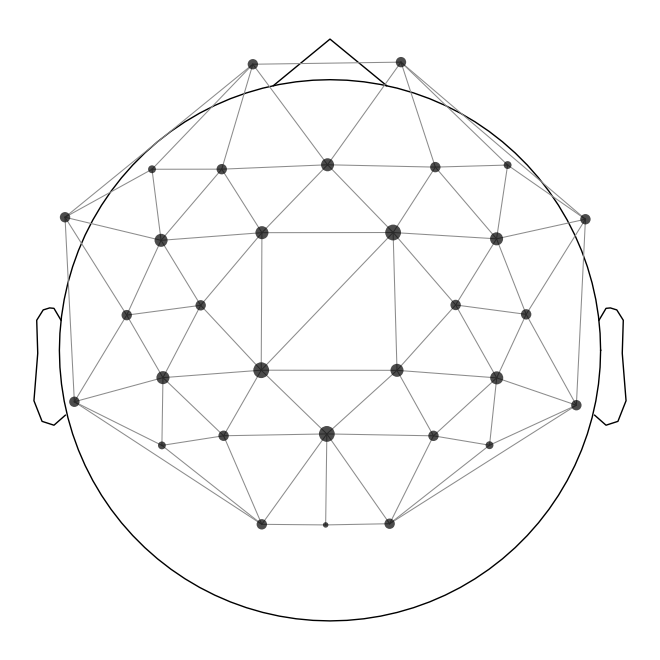

In [67]:
adjacency, ch_names = mne.channels.find_ch_adjacency(pos, ch_type = 'eeg')
mne.viz.plot_ch_adjacency(pos, adjacency, ch_names, kind = '2d')
plt.show()

In [95]:
x1 = da.sel(session = 'baseline').values
x2 = da.sel(session = 'music').values
X = x2 - x1

stat_fun = None

t_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_1samp_test(X, 
                                                                           threshold=None, 
                                                                           stat_fun=stat_fun, 
                                                                           adjacency=None, 
                                                                           out_type = 'indices')


res = {p:{'chan_inds':cluster[0],'chan_labels':np.array(ch_names)[cluster[0]]} for cluster, p in zip(clusters, cluster_p_values)}
n_cluster_signif = sum(cluster_p_values < 0.05)
print(f'{n_cluster_signif} cluster(s) significant')

Using a threshold of 2.045230
stat_fun(H1): min=-3.450981 max=-0.822712
Running initial clustering …
Found 6 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

1 cluster(s) significant


In [94]:
res

{0.103515625: {'chan_inds': array([5, 6]),
  'chan_labels': array(['FC5', 'FC1'], dtype='<U4')},
 0.0341796875: {'chan_inds': array([ 8,  9, 10]),
  'chan_labels': array(['T7', 'TP9', 'CP5'], dtype='<U4')},
 0.06640625: {'chan_inds': array([14, 15]),
  'chan_labels': array(['P7', 'O1'], dtype='<U4')},
 0.2451171875: {'chan_inds': array([17]),
  'chan_labels': array(['O2'], dtype='<U4')},
 0.10546875: {'chan_inds': array([19, 20]),
  'chan_labels': array(['P8', 'TP10'], dtype='<U4')},
 0.37890625: {'chan_inds': array([30]),
  'chan_labels': array(['Fp2'], dtype='<U4')}}

In [96]:
# x1 = da.sel(session = 'baseline').values
# x2 = da.sel(session = 'music').values
# x3 = da.sel(session = 'odor').values
# # X = [logit(x1), logit(x2),logit(x3)]
# X = [x1, x2, x3]

# # stat_fun = None
# # stat_fun = stats.ttest_rel

# def friedman(X):
#     res, p = scipy.stats.friedmanchisquare(X[0],X[1],X[2])
#     return res

# stat_fun = friedman

# F_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(X, 
#                                                                            threshold=None, 
#                                                                            stat_fun=stat_fun, 
#                                                                            adjacency=adjacency, 
#                                                                            n_permutations = 1024,
#                                                                            out_type = 'mask',
#                                                                           seed = 30)

/tmp/ipykernel_2893/762503051.py:26: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  t_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_1samp_test(X, out_type = 'indices', verbose = False)


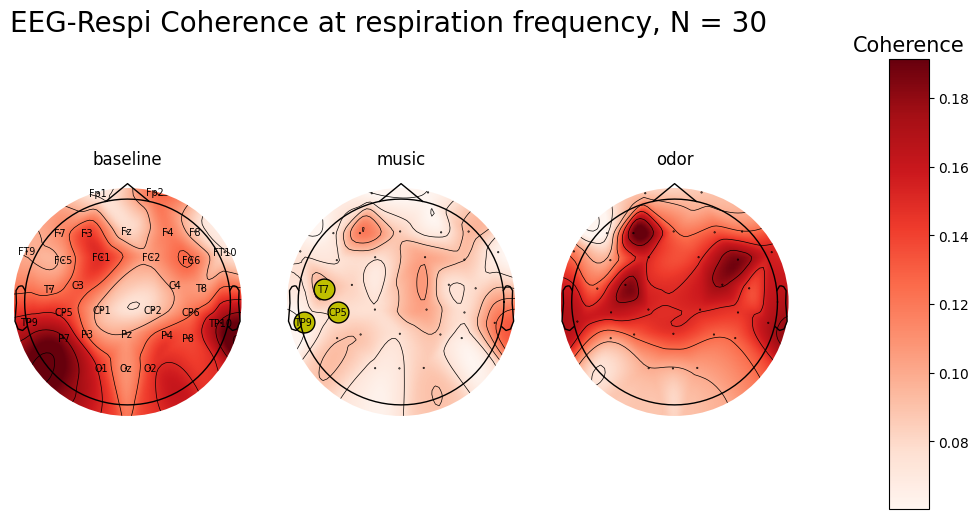

In [106]:
df = coherence.copy()

q_diff = 0

mask_params = dict(markersize=15, markerfacecolor='y')
# mask_params = None

N = df['participant'].unique().size

vmin = df.groupby(['session','chan']).median(numeric_only = True)[metric].quantile(q_diff)
vmax = df.groupby(['session','chan']).median(numeric_only = True)[metric].quantile(1 - q_diff)

fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
fig.suptitle(f'EEG-Respi Coherence at respiration frequency, N = {N}', fontsize = 20, y = 1.1)

for c, session in enumerate(df['session'].unique()):
    ax = axs[c]
    df_mask = dfs_masks[dfs_masks['cond'] == session]
    topo_data = df[df['session'] == session].groupby('chan').median(numeric_only = True)[metric].reindex(eeg_chans)
    if session == 'baseline':
        im, cn = mne.viz.plot_topomap(data = topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax))
    else:
        x1 = da.sel(session = 'baseline').values
        x2 = da.sel(session = session).values
        X = x2 - x1
        t_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_1samp_test(X, out_type = 'indices', verbose = False)
        res = {p:{'chan_inds':cluster[0],'chan_labels':np.array(ch_names)[cluster[0]]} for cluster, p in zip(clusters, cluster_p_values)}
        mask = np.full(len(ch_names), False)
        chan_inds_signif = []
        for cluster, p  in zip(clusters, cluster_p_values):
            if p < 0.05:
                chan_inds_signif.extend(list(cluster[0]))
        mask[chan_inds_signif] = True
        im, cn = mne.viz.plot_topomap(data = topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax), mask = mask, mask_params = mask_params)
    ax.set_title(f'{session}')
        
ax_x_start = 1
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('Coherence',fontsize=15)

plt.show()